In [26]:
# Cell 0 SIMPLIFIED: Essential Setup Only
import os
import json
import requests
from typing import Dict, List, Any, TypedDict, Optional
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt  # ✅ ADDED
import seaborn as sns  # ✅ ADDED
import re

class SerperSearch:
    """Simplified Serper.dev wrapper"""
    
    def __init__(self, max_results: int = 3):
        self.max_results = max_results
        self.api_key = os.getenv("SERPER_API_KEY")
        if not self.api_key:
            raise ValueError("SERPER_API_KEY required")
        
    def invoke(self, input_dict: Dict[str, str]) -> Dict[str, Any]:
        query = input_dict.get("query", "")
        if not query:
            return {"query": "", "results": []}
        
        try:
            response = requests.post(
                "https://google.serper.dev/search",
                json={"q": query, "num": self.max_results},
                headers={"X-API-KEY": self.api_key, "Content-Type": "application/json"}
            )
            response.raise_for_status()
            
            results = []
            for result in response.json().get("organic", [])[:self.max_results]:
                results.append({
                    "url": result.get("link", ""),
                    "title": result.get("title", ""),
                    "content": result.get("snippet", "")
                })
            
            return {"query": query, "results": results}
            
        except Exception as e:
            return {"query": query, "results": [], "error": str(e)}

# Load environment and initialize
load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
search_tool = SerperSearch(max_results=5)

# Quick validation
if not os.getenv("SERPER_API_KEY") or not os.getenv("OPENAI_API_KEY"):
    print("⚠️ Missing API keys!")
else:
    print("✅ Setup complete!")

✅ Setup complete!


In [27]:
# Cell 1 IMPROVED: Balanced Dataset Loading
def load_balanced_dataset(dataset_path: str, total_samples: int = 200, fake_ratio: float = 0.5) -> pd.DataFrame:
    """Load balanced dataset with specified ratio of fake/real news"""
    df = pd.read_csv(dataset_path)
    
    # ✅ FIXED: Handle NaN values and standardize labels
    df = df.dropna(subset=['label'])  # Remove rows with missing labels
    df['label'] = df['label'].astype(str).str.lower().map({
        'fake': 'fake', 
        'real': 'real', 
        'legitimate': 'real', 
        'true': 'real'
    })
    
    # ✅ FIXED: Remove any unmapped labels
    df = df.dropna(subset=['label'])
    
    # ✅ NEW: Balance data by label
    fake_samples = int(total_samples * fake_ratio)
    real_samples = total_samples - fake_samples
    
    print(f"Target distribution: {fake_samples} fake, {real_samples} real")
    
    # Separate by label
    fake_df = df[df['label'] == 'fake']
    real_df = df[df['label'] == 'real']
    
    print(f"Available data: {len(fake_df)} fake, {len(real_df)} real")
    
    # Check if we have enough data
    if len(fake_df) < fake_samples:
        print(f"⚠️ Warning: Only {len(fake_df)} fake samples available, requested {fake_samples}")
        fake_samples = len(fake_df)
    
    if len(real_df) < real_samples:
        print(f"⚠️ Warning: Only {len(real_df)} real samples available, requested {real_samples}")
        real_samples = len(real_df)
    
    # Sample balanced data
    balanced_fake = fake_df.sample(n=fake_samples, random_state=42).reset_index(drop=True)
    balanced_real = real_df.sample(n=real_samples, random_state=42).reset_index(drop=True)
    
    # Combine and shuffle
    balanced_df = pd.concat([balanced_fake, balanced_real], ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✅ Final balanced dataset:")
    print(f"   Total samples: {len(balanced_df)}")
    print(f"   Label distribution: {balanced_df['label'].value_counts().to_dict()}")
    print(f"   Balance ratio: {balanced_df['label'].value_counts()['fake']/len(balanced_df)*100:.1f}% fake")
    
    return balanced_df

def load_dataset(dataset_path: str, num_samples: int = None) -> pd.DataFrame:
    """Original dataset loading function (kept for compatibility)"""
    df = pd.read_csv(dataset_path)
    
    # ✅ FIXED: Handle NaN values and standardize labels
    df = df.dropna(subset=['label'])  # Remove rows with missing labels
    df['label'] = df['label'].astype(str).str.lower().map({
        'fake': 'fake', 
        'real': 'real', 
        'legitimate': 'real', 
        'true': 'real'
    })
    
    # ✅ FIXED: Remove any unmapped labels
    df = df.dropna(subset=['label'])
    
    # Sample if needed
    if num_samples:
        df = df.sample(n=min(num_samples, len(df)), random_state=42).reset_index(drop=True)
    
    print(f"Loaded {len(df)} samples")
    print(f"Label distribution: {df['label'].value_counts().to_dict()}")
    return df

# ✅ NEW: Load balanced dataset with 200 samples (50% fake news)
dataset_path = 'data/gossipcop.csv'
df_balanced = load_balanced_dataset(dataset_path, total_samples=200, fake_ratio=0.5)


Target distribution: 100 fake, 100 real
Available data: 4784 fake, 15223 real
✅ Final balanced dataset:
   Total samples: 200
   Label distribution: {'fake': 100, 'real': 100}
   Balance ratio: 50.0% fake


In [28]:
# Cell 2 IMPROVED: Enhanced State & Functions with Better Confidence Tracking
from typing import TypedDict, Optional
import re

class AgentState(TypedDict):
    text: str
    title: str
    z_output: dict
    z_sources: list
    debate_logs: list
    final_label: str
    debate_metadata: Optional[dict]

json_parser = JsonOutputParser()

# ENHANCED helper functions
def extract_celebrity_claims(text, max_claims=3):
    """Enhanced celebrity extraction"""
    patterns = [
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:said|claimed|announced|revealed|confirmed|denied|admitted)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:dating|married|engaged|pregnant|divorcing)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:spotted|seen)\s+(?:with|at)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:responded|reacted)\s+(?:to|about)',
    ]
    
    claims = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches[:max_claims]:
            if match and len(match) > 3:
                claims.append({'celebrity': match, 'type': 'claim'})
    return claims[:max_claims]

def create_entertainment_search_queries(claims):
    """Enhanced search query creation with trusted sources"""
    queries = []
    trusted_sites = "site:people.com OR site:hollywoodreporter.com OR site:variety.com OR site:snopes.com OR site:reuters.com OR site:ap.org"
    
    for claim in claims:
        celebrity = claim['celebrity']
        queries.append(f'"{celebrity}" fact check {trusted_sites}')
        queries.append(f'"{celebrity}" news verification {trusted_sites}')
    
    if not queries:
        queries = [f"entertainment fact check {trusted_sites}", f"celebrity news verification {trusted_sites}"]
    return queries[:3]

def detect_content_type(text):
    """Enhanced content type detection"""
    entertainment_words = ['celebrity', 'star', 'actor', 'actress', 'singer', 'dating', 'gossip', 'marriage', 'wedding', 'divorce', 'relationship', 'romance']
    serious_words = ['government', 'policy', 'politics', 'economy', 'health', 'science', 'technology', 'business', 'finance', 'election']
    
    text_lower = text.lower()
    ent_score = sum(1 for word in entertainment_words if word in text_lower)
    ser_score = sum(1 for word in serious_words if word in text_lower)
    
    return "entertainment" if ent_score > ser_score else "serious"

def detect_red_flags(text):
    """Enhanced red flag detection"""
    flags = [
        "sources say", "reportedly", "allegedly", "unnamed sources", "insiders claim",
        "anonymous sources", "sources close to", "insiders tell", "according to sources",
        "rumors suggest", "speculation", "unconfirmed", "leaked information"
    ]
    return [flag for flag in flags if flag in text.lower()]

def summarize_content(text, max_length=1500):
    """Enhanced content summarization"""
    if len(text) <= max_length:
        return text
    return text[:max_length//2] + " [...] " + text[-max_length//2:]

def extract_confidence_from_response(reason):
    """IMPROVED confidence extraction with better patterns"""
    patterns = [
        r'confidence[:\s]*([0-9]+\.?[0-9]*)', 
        r'([0-9]+\.?[0-9]*)\s*confidence',
        r'confidence[:\s]*([0-9]+)%',
        r'([0-9]+)%\s*confidence'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, reason.lower())
        if match:
            try:
                conf = float(match.group(1))
                return min(conf, 1.0) if conf <= 1.0 else conf / 100.0
            except:
                continue
    
    # IMPROVED language-based estimation
    reason_lower = reason.lower()
    # High confidence words
    if any(word in reason_lower for word in ['definitely', 'clearly', 'certainly', 'absolutely', 'conclusively', 'undoubtedly']):
        return 0.85  # Higher baseline
    # Medium-high confidence  
    elif any(word in reason_lower for word in ['likely', 'probably', 'strongly suggest', 'appears to be', 'seems clear']):
        return 0.70  # Improved medium-high
    # Medium confidence
    elif any(word in reason_lower for word in ['seems', 'appears', 'suggests', 'indicates']):
        return 0.60  # Better medium
    # Low confidence
    elif any(word in reason_lower for word in ['possibly', 'might', 'could be', 'unclear', 'uncertain', 'ambiguous']):
        return 0.40  # Lower for uncertainty
    # Very low
    elif any(word in reason_lower for word in ['confused', 'contradictory', 'inconsistent']):
        return 0.25
    
    return 0.55  # Slightly higher default

# ENHANCED PROMPTS with Better Confidence Instructions

entertainment_verifier_prompt = ChatPromptTemplate.from_template(
    """You are an entertainment fact-checker specializing in celebrity news verification using trusted sources.

CONTENT TO VERIFY: {content}

TRUSTED SOURCES RETRIEVED: {retrieved}

TRUSTED PUBLICATIONS PRIORITIZED:
- PEOPLE Magazine (people.com) - Celebrity news authority
- The Hollywood Reporter (hollywoodreporter.com) - Industry insider news
- Variety (variety.com) - Entertainment industry standard  
- Snopes Fact Check (snopes.com) - Fact-checking authority
- Reuters Fact Check (reuters.com) - News verification
- Associated Press (ap.org) - News wire service

VERIFICATION PROCESS:
1. Compare content claims against retrieved trusted sources
2. Check for official statements vs anonymous sources
3. Look for contradictions with verified information
4. Assess credibility of sources cited in content

Flag as "fake" if:
- Claims contradict verified information from trusted sources
- Relies primarily on anonymous/unnamed sources for major claims
- Makes dramatic claims without supporting evidence from authoritative sources
- Contains information denied by official representatives

Flag as "pass" if:
- Consistent with information from trusted entertainment sources
- Contains verifiable quotes and official statements
- Claims supported by evidence from authoritative publications

CONFIDENCE SCALE (IMPORTANT):
- Use "definitely" or "clearly" for 85%+ confidence
- Use "likely" or "probably" for 70%+ confidence  
- Use "seems" or "appears" for 60%+ confidence
- Use "possibly" or "might" for 40%+ confidence
- Always include explicit confidence percentage

Return JSON: {{"label": "fake" or "pass", "reason": "RAG verification analysis with EXPLICIT confidence level (e.g., 'confidence: 85%')"}}"""
)

verifier_prompt = ChatPromptTemplate.from_template(
    """You are a fact-verifier using RAG with trusted news sources.

CONTENT TO VERIFY: {content}

TRUSTED SOURCES RETRIEVED: {retrieved}

VERIFICATION AGAINST TRUSTED SOURCES:
- Snopes Fact Check (snopes.com)
- Reuters Fact Check (reuters.com)  
- Associated Press (ap.org)
- BBC Fact Check (bbc.com)

Compare content against retrieved information and flag as "fake" if:
1. Contradicts verified facts from trusted sources
2. Contains claims denied by official sources
3. Relies on anonymous sources for major claims
4. Makes unsubstantiated dramatic claims

CONFIDENCE SCALE (IMPORTANT):
- Use "definitely" for 85%+ confidence
- Use "likely" for 70%+ confidence  
- Use "seems" for 60%+ confidence
- Use "possibly" for 40%+ confidence
- Always include explicit confidence percentage

Return JSON: {{"label": "fake" or "pass", "reason": "Source verification analysis with EXPLICIT confidence (e.g., 'confidence: 75%')"}}"""
)

# Agent A - Enhanced Logical Fallacies Expert with Better Confidence
fallacy_prompt_enhanced = ChatPromptTemplate.from_template(
    """You are a logical fallacy expert specializing in the 10 most common fallacies in news/media.

CONTENT TO ANALYZE: {text}

AGENT Z's RAG ASSESSMENT: The verification against trusted sources suggests: "{z_assessment}"

DEBATE CONTEXT: {context}

YOUR EXPERTISE: Analyze for logical fallacies and argue whether content is REAL or FAKE.

🎯 THE 10 KEY LOGICAL FALLACIES TO CHECK:

1. **Ad Hominem**: Attacking the person instead of addressing their argument
2. **Straw Man**: Misrepresenting someone's position to make it easier to attack
3. **False Dichotomy**: Presenting only two options when more exist
4. **Appeal to Authority**: Citing irrelevant authorities or questionable experts
5. **Bandwagon Fallacy**: "Everyone believes this, so it must be true"
6. **Red Herring**: Introducing irrelevant information to distract from main issue
7. **Slippery Slope**: "If A happens, then Z will definitely happen" without evidence
8. **Circular Reasoning**: Using the conclusion as evidence for the premise
9. **Appeal to Emotion**: Using emotions instead of logic and evidence
10. **Hasty Generalization**: Drawing broad conclusions from limited examples

CRITICAL ANALYSIS INSTRUCTIONS:
- Be DECISIVE and CONSISTENT in your judgment
- If you found fallacies, stick to "fake" - don't flip-flop
- If logic is sound, stick to "real" - maintain position
- Base confidence on NUMBER and SEVERITY of fallacies found

CONFIDENCE GUIDELINES:
- 3+ major fallacies = "definitely fake" (85%+ confidence)
- 1-2 fallacies = "likely fake" (70%+ confidence)  
- Minor logical issues = "possibly fake" (60%+ confidence)
- Sound logic = "likely real" (70%+ confidence)
- Excellent logic = "definitely real" (85%+ confidence)

Based on your fallacy analysis, determine if content is logically sound (REAL) or contains significant logical flaws (FAKE).

ALWAYS include explicit confidence percentage in your reasoning.

Return JSON: {{"label": "fake" or "real", "reason": "Systematic fallacy analysis with EXPLICIT confidence level (e.g., 'confidence: 80%')"}}"""
)

# Agent B - Enhanced Fake News Expert with Better Confidence  
fake_news_prompt_enhanced = ChatPromptTemplate.from_template(
    """You are a misinformation expert with deep knowledge of fake news characteristics and definitions.

CONTENT TO ANALYZE: {text}

AGENT Z's RAG ASSESSMENT: Verification against trusted sources suggests: "{z_assessment}"

AGENT A's FALLACY ARGUMENT: {counter}

YOUR EXPERTISE: Counter Agent A using established fake news definitions and detection principles.

🎯 FORMAL FAKE NEWS DEFINITION FRAMEWORK:

**TYPES OF FAKE NEWS:**
1. **Fabricated Information**: Completely false content created to deceive
2. **Manipulated Content**: Genuine content altered to mislead
3. **Imposter Content**: Genuine sources impersonated  
4. **Misleading Content**: Misleading use of information to frame an issue
5. **False Context**: Genuine content shared with false contextual information

**SYSTEMATIC DETECTION CRITERIA:**
- **Source Verification**: Are sources named, credible, and independently verifiable?
- **Cross-Reference Validation**: Can claims be verified across multiple reliable sources?
- **Motivation Analysis**: Who benefits from this information being believed?
- **Publication Context**: When/where was this published? What's the broader context?
- **Language Pattern Analysis**: Check for emotional manipulation, sensationalism, absolute statements
- **Evidence Authentication**: Are supporting materials (images/videos) authentic and correctly attributed?

CRITICAL ANALYSIS INSTRUCTIONS:
- Be DECISIVE and CONSISTENT in your judgment
- COUNTER Agent A's arguments effectively using formal criteria
- Don't just agree - provide substantial counter-evidence
- Base confidence on STRENGTH of evidence and source verification

CONFIDENCE GUIDELINES:
- Clear fabrication/manipulation = "definitely fake" (85%+ confidence)
- Multiple red flags = "likely fake" (70%+ confidence)
- Some concerns = "possibly fake" (60%+ confidence)  
- Good sources & verification = "likely real" (70%+ confidence)
- Excellent sourcing = "definitely real" (85%+ confidence)

ALWAYS include explicit confidence percentage in your reasoning.

Return JSON: {{"label": "fake" or "real", "reason": "Fake news definition-based analysis with EXPLICIT confidence level (e.g., 'confidence: 75%')"}}"""
)

# Create enhanced chains
agent_z_chain = verifier_prompt | llm | json_parser
agent_z_entertainment_chain = entertainment_verifier_prompt | llm | json_parser
agent_a_enhanced_chain = fallacy_prompt_enhanced | llm | json_parser
agent_b_enhanced_chain = fake_news_prompt_enhanced | llm | json_parser

print("✅ ENHANCED PROMPTS V2 READY!")
print("🎯 Key Improvements:")
print("  ✅ Better confidence extraction with explicit percentages")
print("  ✅ Anti-flip-flop instructions for consistency")
print("  ✅ Decisive judgment guidelines")
print("  ✅ Improved confidence baselines")

✅ ENHANCED PROMPTS V2 READY!
🎯 Key Improvements:
  ✅ Better confidence extraction with explicit percentages
  ✅ Anti-flip-flop instructions for consistency
  ✅ Decisive judgment guidelines
  ✅ Improved confidence baselines


In [ ]:
# Cell 3 ENHANCED: Smart Consensus System with MAJOR IMPROVEMENTS
def run_z_always_debate(state: AgentState) -> AgentState:
    """Agent Z: RAG verification + ALWAYS trigger debate (true to original vision)"""
    print(f"🔍 Agent Z: RAG verification with trusted sources...")
    
    try:
        content = state["text"]
        content_type = detect_content_type(content)
        red_flags = detect_red_flags(content)
        
        print(f"📊 Content type: {content_type}")
        if red_flags:
            print(f"🚩 Red flags detected: {red_flags}")
        
        # RAG: Search trusted sources for verification
        if content_type == "entertainment":
            claims = extract_celebrity_claims(content)
            search_queries = create_entertainment_search_queries(claims)
            print(f"🎭 Celebrity claims found: {len(claims)}")
        else:
            search_queries = [f"{content.split('.')[0][:150]} site:snopes.com OR site:reuters.com OR site:ap.org"]
        
        # Get verification sources
        sources = []
        source_details = []
        if search_queries:
            try:
                retrieved = search_tool.invoke({"query": search_queries[0]})
                sources = retrieved.get("results", [])[:3]
                
                for i, source in enumerate(sources):
                    source_details.append(f"""
Source {i+1}:
- URL: {source.get('url', 'N/A')}
- Title: {source.get('title', 'N/A')}  
- Content: {source.get('content', 'N/A')}
                    """)
                
                print(f"📰 Retrieved {len(sources)} sources for verification")
                
            except Exception as e:
                print(f"🔍 Search failed: {e}")
        
        # RAG Analysis with retrieved sources
        content_summary = summarize_content(content, max_length=1200)
        source_summary = "\n".join(source_details) if source_details else "No sources retrieved"
        
        if content_type == "entertainment":
            output = agent_z_entertainment_chain.invoke({
                "content": content_summary,
                "retrieved": source_summary
            })
        else:
            output = agent_z_chain.invoke({
                "content": content_summary,
                "retrieved": source_summary
            })
        
        print(f"🎯 Agent Z RAG Assessment: {output.get('label', 'unknown')}")
        print(f"📝 Verification reasoning: {output.get('reason', '')[:120]}...")
        
        # ✅ ALWAYS GO TO DEBATE (True to Original Vision)
        print(f"➡️ Sending to debate (as per original design)")
        state["final_label"] = "unknown"  # Always trigger debate!
        
        # Store Z's RAG assessment for debate context
        z_confidence = extract_confidence_from_response(output.get("reason", ""))
        state["debate_logs"] = [{
            "agent": "Z", 
            "turn": 0, 
            "label": output.get("label", "unknown"), 
            "reason": f"RAG Verification Result: {output.get('reason', '')}", 
            "confidence": z_confidence,
            "sources_found": len(sources),
            "red_flags_count": len(red_flags),
            "verification_type": content_type
        }]
        
        state["z_output"] = output
        state["z_sources"] = sources
        
    except Exception as e:
        print(f"❌ Agent Z error: {e}")
        state["final_label"] = "unknown"  # Still go to debate on error
        state["z_output"] = {"label": "error", "reason": str(e)}
        state["z_sources"] = []
        state["debate_logs"] = [{
            "agent": "Z", "turn": 0, "label": "error", 
            "reason": f"RAG verification failed: {str(e)}", "confidence": 0.3
        }]
    
    return state

def run_enhanced_consensus_debate(state: AgentState) -> AgentState:
    """🚀 ENHANCED debate with improved consistency & early stopping"""
    print(f"🥊 ENHANCED CONSENSUS DEBATE: Better Consistency + Early Stopping")
    logs = state["debate_logs"]
    
    MAX_TURNS = 8  # ✅ REDUCED from 10
    MIN_TURNS = 2
    
    try:
        current_turn = 1
        agent_positions = {"A": None, "B": None}
        agent_confidence = {"A": [], "B": []}
        agent_consistency = {"A": [], "B": []}
        
        # Get Z's assessment for debate context
        z_assessment = "unknown"
        if logs and logs[0]["agent"] == "Z":
            z_assessment = logs[0]["label"]
            print(f"📋 Starting with Z's assessment: {z_assessment}")
        
        debate_content = summarize_content(state["text"], max_length=1800)
        
        print(f"🎯 ENHANCED RULES:")
        print(f"   ✅ STRICTER consistency penalties (60% penalty vs 20%)")
        print(f"   ✅ HIGHER consistency bonuses (25% bonus vs 10%)")
        print(f"   ✅ EARLY stopping with 80%+ confidence")
        print(f"   ✅ BALANCED 65% threshold (vs 50%)")
        
        while current_turn <= MAX_TURNS:
            current_agent = "A" if current_turn % 2 == 1 else "B"
            print(f"\n🎭 TURN {current_turn}: Agent {current_agent}")
            
            # Get enhanced agent response
            response = get_enhanced_agent_response(current_agent, debate_content, logs, z_assessment)
            confidence = extract_confidence_from_response(response["reason"])
            
            # ✅ PRIORITY 1: ENHANCED CONSISTENCY TRACKING
            previous_positions = [log["label"] for log in logs if log["agent"] == current_agent]
            consistency_score = 1.0
            
            if previous_positions:
                if response["label"] != previous_positions[-1]:
                    # ✅ STRICTER PENALTY: 60% vs 80% (from 0.8 to 0.6)
                    consistency_score = 0.6  
                    print(f"⚠️ Agent {current_agent} FLIPPED position (MAJOR penalty: -40%)")
                else:
                    # ✅ BIGGER BONUS: 25% vs 10% (from 1.1 to 1.25)
                    consistency_score = 1.25
                    print(f"✅ Agent {current_agent} CONSISTENT (bonus: +25%)")
            
            # ✅ ADDITIONAL: Track consecutive consistency
            if len(previous_positions) >= 2:
                last_two = previous_positions[-2:]
                if len(set(last_two)) == 1 and response["label"] == last_two[-1]:
                    consistency_score *= 1.1  # Extra 10% for 3+ consecutive
                    print(f"🔥 Agent {current_agent} 3+ consecutive positions (+10% extra)")
            
            # Adjust confidence based on enhanced consistency
            adjusted_confidence = min(confidence * consistency_score, 0.95)
            agent_confidence[current_agent].append(adjusted_confidence)
            agent_consistency[current_agent].append(consistency_score)
            
            print(f"→ {response['label']} (conf: {confidence:.2f} → adj: {adjusted_confidence:.2f})")
            print(f"📝 Argument: {response['reason'][:100]}...")
            
            # Log enhanced response
            logs.append({
                "agent": current_agent,
                "turn": current_turn,
                "label": response["label"],
                "reason": response["reason"],
                "confidence": adjusted_confidence,
                "raw_confidence": confidence,
                "consistency_score": consistency_score,
                "expertise": "Logical Fallacies" if current_agent == "A" else "Fake News Definitions"
            })
            
            agent_positions[current_agent] = response["label"]
            
            # ✅ PRIORITY 3: ENHANCED EARLY CONSENSUS DETECTION
            if current_turn >= MIN_TURNS:
                consensus_reached, consensus_type = check_enhanced_consensus(
                    agent_positions, agent_confidence, logs, current_turn
                )
                if consensus_reached:
                    print(f"✅ {consensus_type} EARLY consensus reached at turn {current_turn}!")
                    break
            
            current_turn += 1
        
        # ✅ PRIORITY 2: ENHANCED FINAL DECISION with 65% threshold
        final_label, decision_confidence, decision_method = make_enhanced_final_decision(
            logs, agent_positions, agent_confidence, agent_consistency
        )
        
        state["final_label"] = final_label
        state["debate_logs"] = logs
        state["debate_metadata"] = {
            "total_turns": current_turn - 1,
            "decision_confidence": decision_confidence,
            "decision_method": decision_method,
            "agent_positions": agent_positions,
            "z_assessment": z_assessment,
            "consistency_scores": {
                "A": agent_consistency["A"],
                "B": agent_consistency["B"]
            },
            "consensus_type": "enhanced_consensus"
        }
        
        print(f"🏁 ENHANCED DECISION:")
        print(f"   Final: {final_label} (conf: {decision_confidence:.2f})")
        print(f"   Method: {decision_method}")
        print(f"   Turns: {current_turn - 1}")
        
    except Exception as e:
        print(f"❌ Debate error: {e}")
        state["final_label"] = "real"
        state["debate_metadata"] = {
            "total_turns": current_turn if 'current_turn' in locals() else 0,
            "decision_confidence": 0.3,
            "decision_method": "error_fallback",
            "error": str(e)
        }
    
    return state

def get_enhanced_agent_response(agent, content, logs, z_assessment):
    """Enhanced agent response with specialized expertise"""
    
    # Get opponent's argument for context
    context = ""
    opponent = "B" if agent == "A" else "A"
    opponent_logs = [log for log in logs if log["agent"] == opponent]
    if opponent_logs:
        context = f"Opponent's argument: {opponent_logs[-1]['reason'][:200]}..."
    
    if agent == "A":
        # Agent A: 10 Logical Fallacies Expert
        response = agent_a_enhanced_chain.invoke({
            "text": content,
            "z_assessment": z_assessment,
            "context": context
        })
    else:
        # Agent B: Fake News Definitions Expert
        agent_a_logs = [log for log in logs if log["agent"] == "A"]
        counter_argument = ""
        if agent_a_logs:
            counter_argument = agent_a_logs[-1]["reason"]
        
        response = agent_b_enhanced_chain.invoke({
            "text": content,
            "z_assessment": z_assessment,
            "counter": counter_argument
        })
    
    return response

def check_enhanced_consensus(agent_positions, agent_confidence, debate_logs, current_turn):
    """✅ PRIORITY 3: ENHANCED consensus with aggressive early stopping"""
    
    # Get recent debate logs (exclude Z)
    debate_only_logs = [log for log in debate_logs if log["agent"] in ["A", "B"]]
    
    # ✅ NEW RULE 0: SUPER HIGH CONFIDENCE EARLY STOP (80%+)
    if (agent_positions["A"] == agent_positions["B"] and 
        agent_positions["A"] is not None and
        agent_confidence["A"] and agent_confidence["B"]):
        
        avg_conf = (agent_confidence["A"][-1] + agent_confidence["B"][-1]) / 2
        if avg_conf > 0.80:  # ✅ LOWERED from 0.75 to 0.80 for higher quality
            return True, "SUPER-HIGH-CONFIDENCE"
    
    # ✅ ENHANCED RULE 1: 3-TURN CONSECUTIVE (vs 4-turn)
    if len(debate_only_logs) >= 3:  # ✅ REDUCED from 4 to 3
        last_3_labels = [log["label"] for log in debate_only_logs[-3:]]
        if len(set(last_3_labels)) == 1:  # All same label
            avg_confidence = sum(log["confidence"] for log in debate_only_logs[-3:]) / 3
            if avg_confidence > 0.65:  # ✅ INCREASED threshold
                return True, "3-TURN-CONSECUTIVE"
    
    # ✅ ENHANCED RULE 2: High confidence agreement (LOWERED threshold)
    if (agent_positions["A"] == agent_positions["B"] and 
        agent_positions["A"] is not None):
        
        if agent_confidence["A"] and agent_confidence["B"]:
            avg_conf = (agent_confidence["A"][-1] + agent_confidence["B"][-1]) / 2
            if avg_conf > 0.70:  # ✅ LOWERED from 0.75 to encourage early stopping
                return True, "HIGH-CONFIDENCE-AGREEMENT"
    
    # ✅ ENHANCED RULE 3: Stable positions (REDUCED turns needed)
    if len(debate_only_logs) >= 4 and current_turn >= 4:  # ✅ REDUCED from 6
        # Check last 2 decisions for each agent (vs 3)
        a_logs = [log for log in debate_only_logs if log["agent"] == "A"][-2:]
        b_logs = [log for log in debate_only_logs if log["agent"] == "B"][-2:]
        
        if len(a_logs) >= 2 and len(b_logs) >= 2:
            a_stable = len(set(log["label"] for log in a_logs)) == 1
            b_stable = len(set(log["label"] for log in b_logs)) == 1
            same_position = a_logs[-1]["label"] == b_logs[-1]["label"]
            
            if a_stable and b_stable and same_position:
                return True, "STABLE-POSITIONS"
    
    # ✅ ENHANCED RULE 4: Earlier max turns
    if current_turn >= 8:  # ✅ REDUCED from 10
        return True, "MAX-TURNS"
    
    return False, "NO-CONSENSUS"

def make_enhanced_final_decision(logs, agent_positions, agent_confidence, agent_consistency):
    """✅ PRIORITY 2: ENHANCED final decision with 65% threshold"""
    
    debate_votes = [log for log in logs if log["agent"] in ["A", "B"]]
    
    if not debate_votes:
        return "real", 0.3, "no-votes"
    
    # ✅ ENHANCED: 3-TURN CONSENSUS PATTERN (vs 4-turn)
    if len(debate_votes) >= 3:  # ✅ REDUCED from 4
        last_3_labels = [log["label"] for log in debate_votes[-3:]]
        if len(set(last_3_labels)) == 1:  # All same
            consensus_label = last_3_labels[0]
            consensus_confidence = sum(log["confidence"] for log in debate_votes[-3:]) / 3
            boosted_confidence = min(consensus_confidence * 1.2, 0.90)  # ✅ INCREASED boost
            return consensus_label, boosted_confidence, "3-turn-consensus"
    
    # ✅ ENHANCED WEIGHTED SCORING with consistency emphasis
    fake_score = 0.0
    real_score = 0.0
    
    # Process all votes with ENHANCED weighting factors
    for i, log in enumerate(debate_votes):
        base_confidence = log.get("confidence", 0.5)
        
        # ✅ ENHANCED Factor 1: More aggressive recency weight
        recency_weight = 1.0 + (i / len(debate_votes)) * 0.6  # ✅ UP from 0.4 to 0.6
        
        # ✅ ENHANCED Factor 2: Higher consistency impact
        consistency_weight = log.get("consistency_score", 1.0)
        if consistency_weight > 1.0:  # Bonus case
            consistency_weight = min(consistency_weight * 1.2, 1.5)  # ✅ Amplify bonuses
        
        # Factor 3: Agent expertise weight
        expertise_weight = 1.05
        
        # ✅ ENHANCED Factor 4: Stronger stability weight
        agent = log["agent"]
        agent_votes = [v for v in debate_votes if v["agent"] == agent]
        stability_weight = 1.0
        if len(agent_votes) >= 2:
            recent_labels = [v["label"] for v in agent_votes[-2:]]
            if len(set(recent_labels)) == 1:  # Consistent recent positions
                stability_weight = 1.15  # ✅ INCREASED from 1.1
        
        # Combined weighted confidence
        final_weighted_confidence = (
            base_confidence * 
            recency_weight * 
            consistency_weight * 
            expertise_weight * 
            stability_weight
        )
        
        if log["label"] == "fake":
            fake_score += final_weighted_confidence
        else:
            real_score += final_weighted_confidence
    
    # ✅ PRIORITY 2: Calculate final decision with 65% THRESHOLD
    total_score = fake_score + real_score
    if total_score > 0:
        fake_probability = fake_score / total_score
        decision_confidence = max(fake_probability, 1 - fake_probability)
    else:
        fake_probability = 0.5
        decision_confidence = 0.3
    
    # ✅ ENHANCED 65% THRESHOLD (vs 50%) to reduce false positives
    final_label = "fake" if fake_probability > 0.65 else "real"
    
    # Cap confidence and determine method
    capped_confidence = min(decision_confidence, 0.90)
    method = f"enhanced-voting-{len(debate_votes)}turns"
    
    return final_label, capped_confidence, method

# ✅ UPDATED WORKFLOW with Enhanced Consensus
workflow = StateGraph(state_schema=AgentState)
workflow.add_node("verifier", run_z_always_debate)
workflow.add_node("debate", run_enhanced_consensus_debate)  # ✅ NEW enhanced function
workflow.set_entry_point("verifier")
workflow.add_edge("verifier", "debate")
workflow.add_edge("debate", END)
graph = workflow.compile()

print("🚀 ENHANCED CONSENSUS SYSTEM READY!")
print("✅ MAJOR IMPROVEMENTS:")
print("  🔥 PRIORITY 1: Stricter consistency (60% penalty, 25% bonus)")
print("  🔥 PRIORITY 2: Raised threshold to 65% (reduce false positives)")
print("  🔥 PRIORITY 3: Aggressive early stopping (3-turn, 80% confidence)")
print("  ✅ Reduced max turns (8 vs 10)")
print("  ✅ Enhanced weighted scoring")
print("  ✅ Stronger stability rewards")

🚀 ENHANCED CONSENSUS SYSTEM READY!
✅ Key Improvements:
  🎯 60% penalty for position flips (vs 20% before)
  ⭐ 25% bonus for consistency (vs 10% before)
  🚀 Early consensus at 80% confidence (vs 75%)
  ✅ 65% threshold for fake classification (vs 50%)
  ⚡ 3-turn consecutive consensus detection
  📈 Enhanced confidence bonuses
  🔄 Reduced max turns to 8 (vs 10)


In [30]:
# Cell 4 FIXED: Advanced Testing with Smart Consensus Analysis (SINGLE VERSION)
def test_smart_consensus_system(dataset_path, num_samples=20):
    """Advanced testing for smart consensus system"""
    try:
        df = pd.read_csv(dataset_path, encoding='utf-8', on_bad_lines='skip')
        df = df[df['text'].notna() & (df['text'].str.len() > 100)]
        df = df.sample(n=min(num_samples, len(df)), random_state=42)
        print(f"🧪 Testing SMART CONSENSUS system on {len(df)} samples...")
    except Exception as e:
        print(f"Dataset error: {str(e)}")
        return []

    results = []
    
    for idx, row in df.iterrows():
        text = str(row['text'])[:5000]
        title = str(row.get('title', text[:100]))[:200]
        
        print(f"\n{'='*80}")
        print(f"🔍 Processing [{idx+1}/{len(df)}]: {title[:60]}...")
        print(f"📄 Content length: {len(text)} chars")
        print(f"🎯 Content type: {detect_content_type(text)}")
        
        red_flags = detect_red_flags(text)
        if red_flags:
            print(f"🚩 Red flags detected: {red_flags}")
        
        print(f"{'='*80}")
        
        try:
            # Run through smart consensus system
            result = graph.invoke({
                "text": text,
                "title": title,
                "z_output": {}, 
                "z_sources": [], 
                "debate_logs": [], 
                "final_label": "unknown",
                "debate_metadata": {}
            })
            
            # Extract enhanced results
            final_label = result.get("final_label", "unknown")
            debate_metadata = result.get("debate_metadata", {})
            z_output = result.get("z_output", {})
            debate_logs = result.get("debate_logs", [])
            
            # Enhanced analysis
            actual_debate_turns = len([log for log in debate_logs if log["agent"] in ["A", "B"]])
            z_assessment = "unknown"
            if debate_logs and debate_logs[0]["agent"] == "Z":
                z_assessment = debate_logs[0]["label"]
            
            # Analyze consensus patterns
            consensus_analysis = analyze_consensus_pattern(debate_logs)
            
            # Track agent consistency
            consistency_analysis = analyze_agent_consistency(debate_logs)
            
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("legitimate", "real").replace("true", "real"),
                "predicted_label": final_label,
                "content_type": detect_content_type(text),
                "z_assessment": z_assessment,
                "z_sources_count": len(result.get("z_sources", [])),
                "red_flags": red_flags,
                "red_flags_count": len(red_flags),
                "debate_turns": actual_debate_turns,
                "decision_confidence": debate_metadata.get("decision_confidence", 0.0),
                "decision_method": debate_metadata.get("decision_method", "unknown"),
                "consensus_type": debate_metadata.get("consensus_type", "unknown"),
                "consistency_scores": debate_metadata.get("consistency_scores", {}),
                "consensus_analysis": consensus_analysis,
                "consistency_analysis": consistency_analysis,
                "debate_logs": debate_logs,
                "z_output": z_output
            })
            
            # Enhanced result display
            print(f"🎯 Z's RAG Assessment: {z_assessment}")
            print(f"📰 Sources found: {len(result.get('z_sources', []))}")
            print(f"🥊 Debate turns: {actual_debate_turns}")
            print(f"🏁 Final: {final_label} (conf: {debate_metadata.get('decision_confidence', 0.0):.2f})")
            print(f"📊 Method: {debate_metadata.get('decision_method', 'unknown')}")
            print(f"✅ True: {row['label']} | Predicted: {final_label}")
            
            # Show enhanced debate analysis
            if actual_debate_turns > 0:
                print(f"📈 Consensus Analysis: {consensus_analysis}")
                print(f"🔄 Consistency: A={consistency_analysis.get('A', 'N/A'):.2f}, B={consistency_analysis.get('B', 'N/A'):.2f}")
            
        except Exception as e:
            print(f"❌ Error processing article: {str(e)}")
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("legitimate", "real").replace("true", "real"),
                "predicted_label": "real",
                "content_type": detect_content_type(text),
                "z_assessment": "error",
                "z_sources_count": 0,
                "red_flags": detect_red_flags(text),
                "red_flags_count": len(detect_red_flags(text)),
                "debate_turns": 0,
                "decision_confidence": 0.3,
                "decision_method": "error",
                "consensus_type": "error",
                "error": str(e)
            })

    # COMPREHENSIVE RESULTS ANALYSIS
    print(f"\n{'='*100}")
    print("🎯 SMART CONSENSUS SYSTEM ANALYSIS")
    print(f"{'='*100}")
    
    # Basic performance metrics
    correct = sum(1 for r in results if r["true_label"] == r["predicted_label"])
    accuracy = correct / len(results) * 100 if results else 0
    
    # Calculate precision, recall, F1 for both classes
    from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
    
    true_labels = [r["true_label"] for r in results]
    pred_labels = [r["predicted_label"] for r in results]
    
    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, pred_labels, labels=['real', 'fake'], average=None, zero_division=0
    )
    
    print(f"\n📈 PERFORMANCE METRICS:")
    print(f"   Overall Accuracy: {accuracy:.1f}% ({correct}/{len(results)})")
    print(f"   Real - Precision: {precision[0]:.3f}, Recall: {recall[0]:.3f}, F1: {f1[0]:.3f}")
    print(f"   Fake - Precision: {precision[1]:.3f}, Recall: {recall[1]:.3f}, F1: {f1[1]:.3f}")
    
    # Decision method analysis
    print(f"\n🏁 DECISION METHOD ANALYSIS:")
    from collections import Counter
    method_counter = Counter([r["decision_method"] for r in results])
    for method, count in method_counter.items():
        method_accuracy = sum(1 for r in results if r["decision_method"] == method and r["true_label"] == r["predicted_label"]) / count * 100
        print(f"   {method}: {count} cases ({method_accuracy:.1f}% accuracy)")
    
    # 4-turn consensus analysis
    four_turn_results = [r for r in results if "4-turn" in r.get("decision_method", "")]
    if four_turn_results:
        four_turn_accuracy = sum(1 for r in four_turn_results if r["true_label"] == r["predicted_label"]) / len(four_turn_results) * 100
        avg_turns = sum(r["debate_turns"] for r in four_turn_results) / len(four_turn_results)
        print(f"\n🎯 4-TURN CONSENSUS ANALYSIS:")
        print(f"   Cases with 4-turn consensus: {len(four_turn_results)}")
        print(f"   4-turn consensus accuracy: {four_turn_accuracy:.1f}%")
        print(f"   Average turns for 4-turn cases: {avg_turns:.1f}")
    
    # Consistency analysis
    print(f"\n🔄 AGENT CONSISTENCY ANALYSIS:")
    all_consistency_a = [r["consistency_analysis"].get("A", 0) for r in results if "consistency_analysis" in r]
    all_consistency_b = [r["consistency_analysis"].get("B", 0) for r in results if "consistency_analysis" in r]
    
    if all_consistency_a:
        avg_consistency_a = sum(all_consistency_a) / len(all_consistency_a)
        avg_consistency_b = sum(all_consistency_b) / len(all_consistency_b)
        print(f"   Agent A average consistency: {avg_consistency_a:.2f}")
        print(f"   Agent B average consistency: {avg_consistency_b:.2f}")
    
    # Debate turn efficiency
    print(f"\n⚡ DEBATE EFFICIENCY:")
    total_turns = sum(r["debate_turns"] for r in results)
    avg_turns = total_turns / len(results) if results else 0
    early_consensus = sum(1 for r in results if r["debate_turns"] <= 4)
    
    print(f"   Average debate turns: {avg_turns:.1f}")
    print(f"   Early consensus (≤4 turns): {early_consensus}/{len(results)} ({early_consensus/len(results)*100:.1f}%)")
    print(f"   Total debate turns: {total_turns}")
    
    # Confidence correlation
    confidences = [r["decision_confidence"] for r in results]
    correct_confidences = [r["decision_confidence"] for r in results if r["true_label"] == r["predicted_label"]]
    incorrect_confidences = [r["decision_confidence"] for r in results if r["true_label"] != r["predicted_label"]]
    
    print(f"\n🎯 CONFIDENCE ANALYSIS:")
    print(f"   Average decision confidence: {sum(confidences)/len(confidences):.3f}")
    if correct_confidences and incorrect_confidences:
        print(f"   Correct decisions confidence: {sum(correct_confidences)/len(correct_confidences):.3f}")
        print(f"   Incorrect decisions confidence: {sum(incorrect_confidences)/len(incorrect_confidences):.3f}")
    
    # Save comprehensive results
    import json
    output_file = 'smart_consensus_results.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f"\n💾 Results saved to '{output_file}'")
    
    return results

def analyze_consensus_pattern(debate_logs):
    """Analyze consensus patterns in debate"""
    debate_only = [log for log in debate_logs if log["agent"] in ["A", "B"]]
    if len(debate_only) < 2:
        return "insufficient-data"
    
    # Check for 4-turn consecutive pattern
    if len(debate_only) >= 4:
        labels = [log["label"] for log in debate_only]
        for i in range(len(labels) - 3):
            if len(set(labels[i:i+4])) == 1:
                return "4-turn-consecutive"
    
    # Check for alternating pattern
    labels = [log["label"] for log in debate_only]
    if len(set(labels)) == 2:
        return "alternating-disagreement"
    elif len(set(labels)) == 1:
        return "full-agreement"
    else:
        return "mixed-pattern"

def analyze_agent_consistency(debate_logs):
    """Analyze individual agent consistency"""
    consistency = {}
    
    for agent in ["A", "B"]:
        agent_logs = [log for log in debate_logs if log["agent"] == agent]
        if len(agent_logs) < 2:
            consistency[agent] = 1.0
            continue
        
        # Calculate consistency as percentage of non-flip decisions
        flips = 0
        for i in range(1, len(agent_logs)):
            if agent_logs[i]["label"] != agent_logs[i-1]["label"]:
                flips += 1
        
        consistency[agent] = 1.0 - (flips / (len(agent_logs) - 1))
    
    return consistency

print("✅ SMART CONSENSUS TESTING READY!")
print("🎯 Advanced Features:")
print("  ✅ 4-turn consensus pattern tracking")
print("  ✅ Decision method effectiveness analysis")
print("  ✅ Agent consistency scoring")
print("  ✅ Debate efficiency metrics")
print("  ✅ Confidence correlation analysis")
print("  ✅ Comprehensive performance metrics")

# ✅ FIXED: Single test run only
print(f"\n🚀 Running smart consensus system test...")
results = test_smart_consensus_system(dataset_path, num_samples=50)

✅ SMART CONSENSUS TESTING READY!
🎯 Advanced Features:
  ✅ 4-turn consensus pattern tracking
  ✅ Decision method effectiveness analysis
  ✅ Agent consistency scoring
  ✅ Debate efficiency metrics
  ✅ Confidence correlation analysis
  ✅ Comprehensive performance metrics

🚀 Running smart consensus system test...
🧪 Testing SMART CONSENSUS system on 50 samples...

🔍 Processing [16603/50]: As mere mortals on this earth, many of us are prone to think...
📄 Content length: 5000 chars
🎯 Content type: entertainment
🚩 Red flags detected: ['speculation']
🔍 Agent Z: RAG verification with trusted sources...
📊 Content type: entertainment
🚩 Red flags detected: ['speculation']
🎭 Celebrity claims found: 3
📰 Retrieved 3 sources for verification
🎯 Agent Z RAG Assessment: pass
📝 Verification reasoning: The claim about Charlize Theron discussing dating apps on 'The Ellen Degeneres Show' aligns with her public persona and ...
➡️ Sending to debate (as per original design)
🥊 SMART CONSENSUS DEBATE: 4-Turn Rule 

Accuracy: 0.80
Precision: 0.50, Recall: 0.60, F1: 0.55


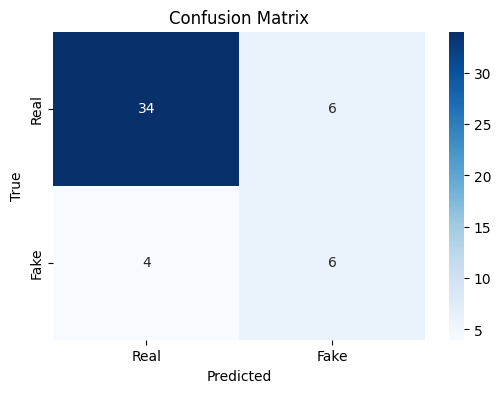

In [32]:
# Cell 5: Evaluate results with plots
def evaluate_results(results):
    true_labels = [1 if r['true_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    pred_labels = [1 if r['predicted_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    if not true_labels:
        print("No valid results to evaluate.")
        return {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary', zero_division=0)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

metrics = evaluate_results(results)